---

<h3 style="text-align: center;"><b>Image segmentation</b></h3>

---

В качестве домашней работы предлагается улучшить сегментацию, сделанную на семинаре. В качестве основы для даталоэдера используйте функцию __keras_generator__. Попробуйте сделать следующие улучшения:
1. Брать случайный кроп, а не ресайзить исходное изображение. Попробуйте разные размеры кропов, на каких результат получается лучше? Кроп какого максимального размера помещается в вашу видеокарту?
2. Добавить аугментаций. Например, можно поворачивать картинки или добавлять случайный шум

Эти два пункта улучшения можно сделать с помощью библиотеки __albumentations__ https://github.com/albu/albumentations . Пример использования можно посмотреть в конце семинарского ноутбука.

In [0]:
!wget ''


http://: Invalid host name.
UnZip 6.00 of 20 April 2009, by Info-ZIP.  Maintained by C. Spieler.  Send
bug reports using http://www.info-zip.org/zip-bug.html; see README for details.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make direct

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd



In [0]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation



In [0]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

In [0]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout, VerticalFlip,
RandomBrightnessContrast, RandomGamma)




# Data reading

In [0]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img



In [0]:
!unzip -q /content/drive/My\ Drive/Colab\ Notebooks/data_car.zip -d data_car



replace data_car/data/train/00087a6bd4dc_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [0]:
df = pd.read_csv('data_car/data/train_masks.csv')

In [0]:
train_df = df.sample(frac=0.8, random_state=200)
val_df = df.drop(train_df.index)

In [0]:
img_name, mask_rle = train_df.iloc[4]

img = cv2.imread('data_car/data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

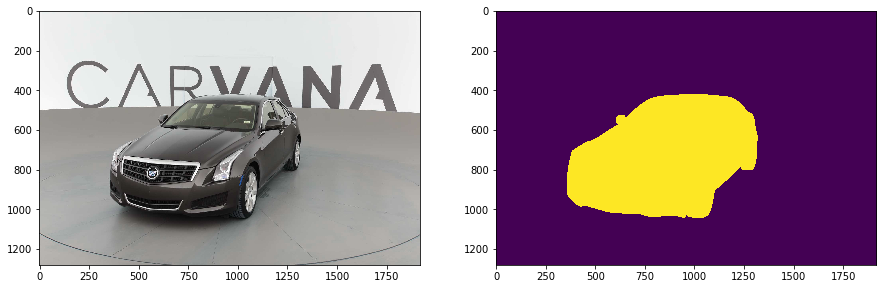

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

# Augmentation (rotate, cut, smooth, flip, brightness)

In [0]:
def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(384,384),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        VerticalFlip(), Transpose(), OpticalDistortion(distort_limit=2, shift_limit=0.5)], p=0.3),
            RandomBrightnessContrast(p=0.8),    
       RandomGamma(p=0.8)

    ],
        p=p)





In [0]:
!pip install git+https://github.com/qubvel/segmentation_models


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-hgbhz2tq
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-hgbhz2tq
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 81kB 5.1MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-__na9323/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


Batch generationg with preprocessing for segmentation_model

In [0]:
from segmentation_models import PSPNet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [0]:
BACKBONE = 'vgg16'
preprocess_input = get_preprocessing(BACKBONE)

In [0]:
def keras_generator_crop(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data_car/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            data = {'image': img.astype('uint8'), 'mask': mask}
            augmentation = strong_aug(p=1.0)
            augmented = augmentation(**data)
            crop_img, crop_mask = augmented["image"], augmented["mask"]
            
            
            
            
            x_batch += [ crop_img]
            y_batch += [crop_mask]

        x_batch = preprocess_input(np.array(x_batch))/ 255.
        y_batch = np.array(y_batch)

        yield x_batch, y_batch

# Architecture PSPNet, backbone VGG16 

In [0]:


# load your data


# preprocess input
#x_train, y_train = keras_generator(train_df, 64)
#x_train = preprocess_input(x_train)

#x_val, y_val = keras_generator(val_df, 16)
#x_val = preprocess_input(x_val)

# define model
model = PSPNet(BACKBONE, encoder_weights='imagenet')
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'sparse_categorical_crossentropy')


# fit model
model.fit_generator(keras_generator_crop(train_df, 16),
    validation_data=keras_generator_crop(val_df, 16),
                    callbacks=None,
    
    epochs=20,
    steps_per_epoch=100,
    validation_steps= 50,
                    verbose=1,
             
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0
                   )



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
100/100 [==============================] - 128s 1s/step - loss: 0.3495 - val_loss: 0.1619
Epoch 2/20
100/100 [==============================] - 119s 1s/step - loss: 0.1337 - val_loss: 0.2075
Epoch 3/20
100/100 [==============================] - 116s 1s/step - loss: 0.1378 - val_loss: 0.1745
Epoch 4/20
100/100 [==============================] - 117s 1s/step - loss: 0.1081 - val_loss: 0.0862
Epoch 5/20
100/100 [==============================] - 116s 1s/step - loss: 0.0806 - val_loss: 0.1384
Epoch 6/20
100/100 [==============================] - 118s 1s/step - loss: 0.0702 - val_loss: 0.0853
Epoch 7/20
100/100 [==============================] - 116s 1s/step - loss: 0.0586 - val_loss: 0.0897
Epoch 8/20
100/100 [==============================] - 117s 1s/step - loss: 0.0607 - val_loss: 0

In [0]:
model.save('model.h5') 

In [1]:
# Generation for full-size pics

In [0]:
def keras_generator_full(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data_car/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (384,384), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (384,384), interpolation=cv2.INTER_LINEAR)
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = preprocess_input(np.array(x_batch))/255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [0]:
for x, y in keras_generator_full(train_df, 16):
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


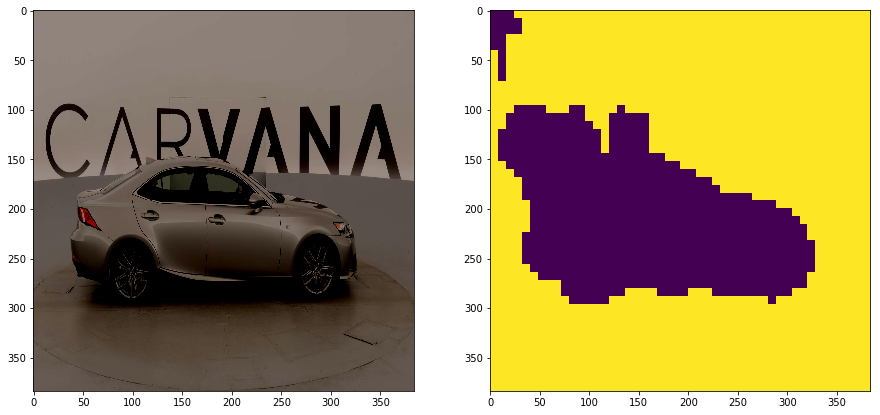

In [0]:

pred = model.predict(x)#.shape

im_id = 4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

In [0]:
# BACKBONE = 'densenet121'

In [0]:
BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

In [0]:
model_1 = PSPNet(BACKBONE, encoder_weights='imagenet')
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model_1.compile(adam, 'sparse_categorical_crossentropy')


# fit model
model_1.fit_generator(keras_generator_crop(train_df, 16),
    validation_data=keras_generator_crop(val_df, 16),
                    callbacks=None,
    
    epochs=20,
    steps_per_epoch=100,
    validation_steps= 50,
                    verbose=1,
             
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0
                   )




Epoch 1/20
100/100 [==============================] - 134s 1s/step - loss: 0.3413 - val_loss: 0.1410
Epoch 2/20
100/100 [==============================] - 110s 1s/step - loss: 0.1182 - val_loss: 0.1415
Epoch 3/20
100/100 [==============================] - 111s 1s/step - loss: 0.0877 - val_loss: 0.1108
Epoch 4/20
100/100 [==============================] - 111s 1s/step - loss: 0.0822 - val_loss: 0.0795
Epoch 5/20
100/100 [==============================] - 110s 1s/step - loss: 0.0713 - val_loss: 0.0641
Epoch 6/20
100/100 [==============================] - 111s 1s/step - loss: 0.0637 - val_loss: 0.0554
Epoch 7/20
100/100 [==============================] - 111s 1s/step - loss: 0.0527 - val_loss: 0.0457
Epoch 8/20
100/100 [==============================] - 111s 1s/step - loss: 0.0586 - val_loss: 0.0471
Epoch 9/20
100/100 [==============================] - 112s 1s/step - loss: 0.0467 - val_loss: 0.0530
Epoch 10/20
100/100 [==============================] - 110s 1s/step - loss: 0.0484 - val_lo

In [0]:
model_1.save('model_1.h5') 

In [0]:
def keras_generator_full_2(gen_df, batch_size):
    while True:
        x_batch_true = []
        y_batch = []
        x_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data_car/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (384,384), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (384,384), interpolation=cv2.INTER_LINEAR)
            
            x_batch_true += [img]
            x_batch += [img]
            y_batch += [mask]

        x_batch_true = (np.array(x_batch_true))/255.
        x_batch = preprocess_input(np.array(x_batch))/255.
        
        y_batch = np.array(y_batch)

        yield x_batch, x_batch_true, np.expand_dims(y_batch, -1)

In [0]:
for x, x_true, y in keras_generator_full_2(train_df, 16):
    break

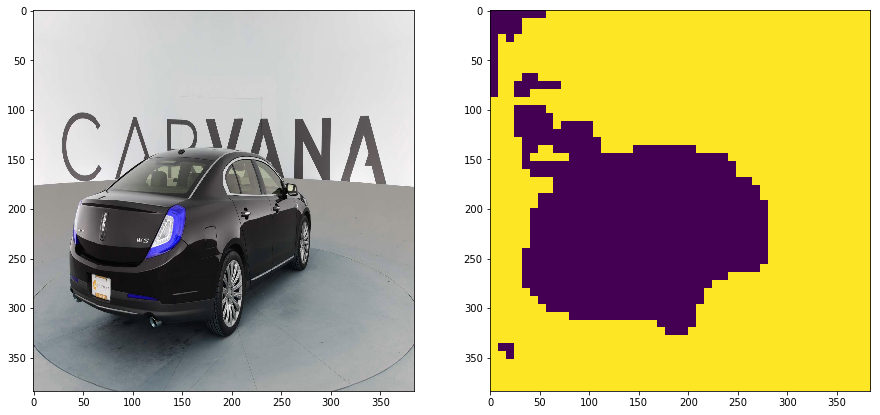

In [0]:
pred_1 = model_1.predict(x)#.shape

im_id = 6
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x_true[im_id])
axes[1].imshow(pred_1[im_id, ..., 0] >0.5)

plt.show()

---

In [0]:
# Attempt Test Time Augmentation

In [0]:
flip = VerticalFlip(p=1.0)





In [0]:
def keras_generator_2(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        x_batch_true = []
        x_flipped = []
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data_car/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            data = {'image': img.astype('uint8'), 'mask': mask}
            flipped = flip(**data)
            img_f, mask_f = flipped["image"], flipped["mask"]
            img_f = cv2.resize(img_f, (384, 384))
            mask_f = cv2.resize(mask_f, (384, 384))
            
            
            img = cv2.resize(img, (384,384), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (384,384), interpolation=cv2.INTER_LINEAR)
            
            x_flipped += [img_f]
            x_batch += [img]
            y_batch += [mask]
            


            
        x_batch_true = (np.array(x_batch))/ 255. 
        x_batch = preprocess_input(np.array(x_batch))/ 255.
        x_flipped = preprocess_input(np.array(x_flipped))/ 255.
        y_batch = np.array(y_batch)

        yield x_batch, x_batch_true, x_flipped, y_batch

In [0]:
for x, x_true, x_flip, y in keras_generator_2(train_df, 16):
    break



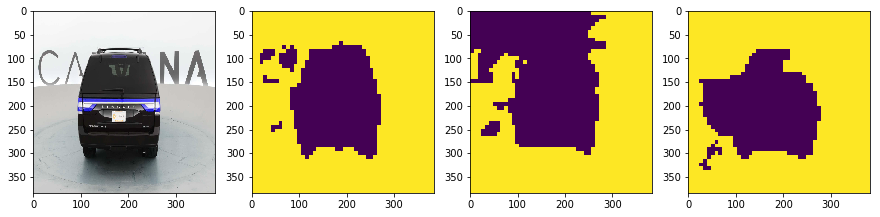

In [0]:
pred_1 = model_1.predict(x)#.shape
pred_2 = model_1.predict(x_flip)
pred = (pred_1 + np.flipud(pred_2))/2
im_id = 7
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
axes[0].imshow(x_true[im_id])
axes[1].imshow(pred_1[im_id, ..., 0] >0.5)
axes[2].imshow(np.flipud(pred_2[im_id, ..., 0] >0.5))
axes[3].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

## densenet121 perfoms better accuracy than VGG16